# Hotdog vs Not hotdog

## Introduction

The purpose of this exercise is to develop a model that distinguishes hotdogs from not hotdogs.

## Set up

In [1]:
%matplotlib inline

In [2]:
%pwd

u'D:\\ML\\fastai\\Projects\\hotdog_nothotdog'

In [4]:
#Create reference to important directories
import os, sys
current_dir = os.getcwd()
HOTDOG_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data'

In [5]:
#Get relative imports to directories above hotdog_nothotdog/
#sys.path.insert(1, os.path.join(sys.path[0], '..'))

#Import utils
from utils import *
from vgg16 import Vgg16

Using Theano backend.


In [6]:
from __future__ import division,print_function
import json
#glob for finding all the pathnames matching a specified pattern according to the rules used by the Unix shell
from glob import glob
#numpy import
import numpy as np
#scipy import
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [7]:
#numpy modules and scipy modules import
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

#keras import
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

#bcolz for saving arrays
import bcolz

In [8]:
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir = fname, mode = 'w');
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

## Action plan

1. Create sample sets and set data directories
2. Train the original vgg16 model
3. Modify the original model and retrain the last layer
4. Drop out
5. Data augmentation
6. Batch normalisation
7. Generate predictions
8. Validate predictions

## Create sample sets and data directories

In [9]:
%cd $DATA_HOME_DIR

path = DATA_HOME_DIR + '/'
#path = DATA_HOME_DIR + '/sample/'
sample_path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/'
results_path = DATA_HOME_DIR + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid/'

D:\ML\fastai\Projects\hotdog_nothotdog\data


In [16]:
#Run bash below to move original images from other directories to train directories
#$ find D:/ML/fastai/Projects/hotdog_nothotdog/data/food-101/images/all/ -type f | shuf -n 1800 | xargs -I file 
#mv file 'D:\ML\fastai\Projects\hotdog_nothotdog\data\train\nothotdog'

In [329]:
#%cd $DATA_HOME_DIR/train/hotdog

#g = glob('*.jpg')
#shuf = np.random.permutation(g)
#for i in range(250):
#    os.rename(shuf[i], DATA_HOME_DIR+'/test/'+shuf[i])

D:\ML\fastai\Projects\hotdog_nothotdog\data\train\hotdog


In [339]:
#%cd $train_path/hotdog

D:\ML\fastai\Projects\hotdog_nothotdog\data\train\hotdog


In [336]:
#g = glob('*.jpg')
#shuf = np.random.permutation(g)
#for i in range(500):
#    os.rename(shuf[i], DATA_HOME_DIR+'/valid/'+shuf[i])

In [337]:
from shutil import copyfile

In [340]:
#g = glob('*.jpg')
#shuf = np.random.permutation(g)
#for i in range(200):
#    copyfile(shuf[i], sample_path+'/train/hotdog/'+shuf[i])

In [343]:
#%cd $valid_path/hotdog

D:\ML\fastai\Projects\hotdog_nothotdog\data\valid\hotdog


In [344]:
#g = glob('*.jpg')
#shuf = np.random.permutation(g)
#for i in range(100):
#    copyfile(shuf[i], sample_path+'/valid/hotdog/'+shuf[i])

## Train the original vgg16 model

In [11]:
vgg = Vgg16()
model = vgg.model

In [12]:
#Set batch size and number of epoch
batch_size = 32
no_of_epochs = 5

In [13]:
#Finetune
batches = vgg.get_batches(train_path, batch_size = batch_size)
val_batches = vgg.get_batches(valid_path, batch_size = batch_size*2)
vgg.finetune(batches)

model.optimizer.lr = 0.01

Found 5100 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
trn_data = get_data(path+'train')
val_data = get_data(path+'valid')

trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(trn_classes)
val_labels = onehot(val_classes)

Found 5100 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
trn_data.shape

(5100L, 3L, 224L, 224L)

In [16]:
val_data.shape

(1000L, 3L, 224L, 224L)

In [17]:
#Save weights
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print ("Running epoch: %d" % epoch)
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d5.h5' % epoch
    model.save_weights(results_path+latest_weights_filename)
print ("Completed %s fit operations" % no_of_epochs)

Running epoch: 0
Epoch 1/1
5100/5100 [==============================] - 1598s - loss: 1.1077 - acc: 0.8980 - val_loss: 1.0418 - val_acc: 0.9160
Running epoch: 1
Epoch 1/1
5100/5100 [==============================] - 1571s - loss: 1.1346 - acc: 0.9120 - val_loss: 1.1486 - val_acc: 0.9190
Running epoch: 2
Epoch 1/1
5100/5100 [==============================] - 1589s - loss: 1.0508 - acc: 0.9229 - val_loss: 0.8046 - val_acc: 0.9400
Running epoch: 3
Epoch 1/1
5100/5100 [==============================] - 1598s - loss: 1.1807 - acc: 0.9127 - val_loss: 0.9451 - val_acc: 0.9310
Running epoch: 4
Epoch 1/1
5100/5100 [==============================] - 1592s - loss: 1.0826 - acc: 0.9229 - val_loss: 1.0669 - val_acc: 0.9250
Completed 5 fit operations


## Modify the original model and retrain the revised model

In [18]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [19]:
model.pop()
for layer in model.layers: layer.trainable = False

In [20]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [21]:
model.add(Dense(2, activation='softmax'))

In [22]:
??vgg.finetune

In [23]:
gen = image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size = batch_size, shuffle = True)
val_batches = gen.flow(val_data, val_labels, batch_size = batch_size, shuffle = False)

In [24]:
def fit_model(model, batches, val_batches, nb_epoch = 1):
    model.fit_generator(batches, samples_per_epoch=batches.n, nb_epoch = nb_epoch,
                       validation_data=val_batches, nb_val_samples= val_batches.n)

In [25]:
opt=RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [27]:
fit_model(model, batches, val_batches, nb_epoch = 5)

Epoch 1/5
5100/5100 [==============================] - 1581s - loss: 4.0237 - acc: 0.7441 - val_loss: 1.4144 - val_acc: 0.9100
Epoch 2/5
5100/5100 [==============================] - 1582s - loss: 2.0084 - acc: 0.8733 - val_loss: 1.3130 - val_acc: 0.9170
Epoch 3/5
5100/5100 [==============================] - 1581s - loss: 1.7034 - acc: 0.8924 - val_loss: 2.7496 - val_acc: 0.8260
Epoch 4/5
5100/5100 [==============================] - 1581s - loss: 1.5676 - acc: 0.9012 - val_loss: 1.3374 - val_acc: 0.9140
Epoch 5/5
5100/5100 [==============================] - 1580s - loss: 1.4348 - acc: 0.9098 - val_loss: 1.5756 - val_acc: 0.9000


In [28]:
#Set up path for model_path
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [29]:
model.save_weights(model_path+'finetune1.h5')

In [30]:
model.load_weights(model_path+'finetune1.h5')

In [31]:
model.evaluate(val_data, val_labels)

1000/1000 [==============================] - 264s   


[1.5756402702331576, 0.90000000000000002]

In [32]:
preds = model.predict_classes(val_data, batch_size = batch_size)
probs = model.predict_proba(val_data, batch_size = batch_size) [:, 0]

1000/1000 [==============================] - 266s   


In [33]:
cm = confusion_matrix(val_classes, preds)

[[482  18]
 [ 82 418]]


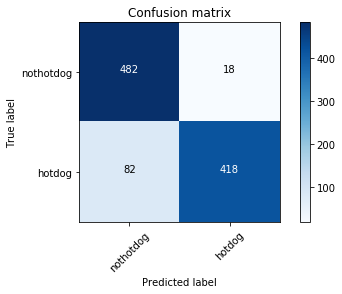

In [34]:
plot_confusion_matrix(cm, {'hotdog':0, 'nothotdog':1})

## Retrain all dense layers after retraining the final layer

In [35]:
layers = model.layers
#Index of the first dense layer
first_dense_idx = [index for index, layer in enumerate(layers) if type(layer) is Dense][0]
#Set the first dense layer and subsequent layers trainable
for layer in layers[first_dense_idx:]: layer.trainable = True

In [36]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 5)

Epoch 1/5
5100/5100 [==============================] - 1595s - loss: 1.5774 - acc: 0.8992 - val_loss: 1.1837 - val_acc: 0.9240
Epoch 2/5
5100/5100 [==============================] - 1592s - loss: 1.3271 - acc: 0.9163 - val_loss: 1.3207 - val_acc: 0.9180
Epoch 3/5
5100/5100 [==============================] - 1582s - loss: 1.3368 - acc: 0.9155 - val_loss: 1.3010 - val_acc: 0.9170
Epoch 4/5
5100/5100 [==============================] - 1580s - loss: 1.3440 - acc: 0.9147 - val_loss: 1.1465 - val_acc: 0.9280
Epoch 5/5
5100/5100 [==============================] - 1579s - loss: 1.2667 - acc: 0.9194 - val_loss: 1.3539 - val_acc: 0.9160


In [37]:
model.save_weights(model_path+'finetune2.h5')

## Reduce underfitting

Currently the model is underfitting (accuracy of training set < accuracy of validation set). I will make dropout rates to zero so that I can check whether the model is underfitting due to inappropriate dropout rates.

In [38]:
#Change the working model
vgg = vgg_ft(2)

In [39]:
#Reload the previous weights that were retrained in all dense layers
model.load_weights(model_path+'finetune2.h5')

In [40]:
layers = model.layers
#Index of the last convolutional layer
last_conv_idx = [index for index, layer in enumerate(layers) if type(layer) is Convolution2D][-1]

In [41]:
last_conv_idx

30

In [42]:
layers[last_conv_idx]

In [43]:
#Make the model for convolutional layers so that we use the model as it is
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

In [44]:
#Make the model for dense (fully connected) layers
fc_layers = layers[last_conv_idx+1:]

In [45]:
batches = get_batches(train_path, shuffle = False, batch_size = batch_size)
val_batches = get_batches(valid_path, shuffle = False, batch_size = batch_size)

Found 5100 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [46]:
batches.class_indices

{'hotdog': 0, 'nothotdog': 1}

In [47]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [48]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [49]:
save_array(model_path+'train_convlayer_features.bc', trn_features)
save_array(model_path+'valid_convlayer_features.bc', val_features)

In [50]:
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [51]:
trn_features.shape

(5100L, 512L, 14L, 14L)

In [52]:
#Copy the weights from the pre-trained model
def proc_wgts(layer):
    return [o for o in layer.get_weights()]

In [53]:
opt = RMSprop(lr=0.00001, rho=0.7)

In [54]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])
    for l1, l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))
        
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
fc_model = get_fc_model()

In [56]:
fc_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_16 (MaxPooling2D)   (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 25088)         0           maxpooling2d_16[0][0]            
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 4096)          102764544   flatten_4[0][0]                  
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 4096)          0           dense_13[0][0]                   
___________________________________________________________________________________________

In [57]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8,batch_size=batch_size, 
             validation_data = (val_features, val_labels))

Train on 5100 samples, validate on 1000 samples
Epoch 1/8
5100/5100 [==============================] - 209s - loss: 1.0853 - acc: 0.9314 - val_loss: 1.2432 - val_acc: 0.9210
Epoch 2/8
5100/5100 [==============================] - 261s - loss: 1.0258 - acc: 0.9353 - val_loss: 1.2240 - val_acc: 0.9240
Epoch 3/8
5100/5100 [==============================] - 406s - loss: 1.0781 - acc: 0.9322 - val_loss: 1.1597 - val_acc: 0.9280
Epoch 4/8
5100/5100 [==============================] - 519s - loss: 0.9781 - acc: 0.9376 - val_loss: 1.0025 - val_acc: 0.9370
Epoch 5/8
5100/5100 [==============================] - 522s - loss: 0.9920 - acc: 0.9375 - val_loss: 1.0590 - val_acc: 0.9330
Epoch 6/8
5100/5100 [==============================] - 562s - loss: 0.8527 - acc: 0.9461 - val_loss: 1.0784 - val_acc: 0.9320
Epoch 7/8
5100/5100 [==============================] - 627s - loss: 0.8152 - acc: 0.9486 - val_loss: 1.0992 - val_acc: 0.9300
Epoch 8/8
5100/5100 [==============================] - 605s - loss: 0.

In [58]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [59]:
fc_model.load_weights(model_path+'no_dropout.h5')

## Reduce overfitting

Since I made the dropout rates to zero, the model is overfitting at the moment. I will attempt to reduce overfitting through data augmentation and batch normalisation.

### Through data augmentation

In [60]:
#Through ImageDataGenerator, augment the data
gen = image.ImageDataGenerator(rotation_range=5, width_shift_range=0.1,
                              height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [61]:
#Then pass the augmented data into batches, we should not change valid set images
batches = get_batches(path+'train', gen, batch_size = batch_size)

Found 5100 images belonging to 2 classes.


In [62]:
fc_model = get_fc_model()

In [63]:
#Set conv_model not trainable
for layer in conv_model.layers:
    layer.trainable = False
#Just add the fully connected layers to the conv_model
conv_model.add(fc_model)

In [64]:
conv_model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy']) 

In [65]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
5100/5100 [==============================] - 1848s - loss: 1.3408 - acc: 0.9153 - val_loss: 1.2054 - val_acc: 0.9250
Epoch 2/8
5100/5100 [==============================] - 1889s - loss: 1.2721 - acc: 0.9200 - val_loss: 1.1942 - val_acc: 0.9250
Epoch 3/8
5100/5100 [==============================] - 2016s - loss: 1.1477 - acc: 0.9275 - val_loss: 1.1444 - val_acc: 0.9290
Epoch 4/8
5100/5100 [==============================] - 2116s - loss: 1.1882 - acc: 0.9249 - val_loss: 1.1189 - val_acc: 0.9270
Epoch 5/8
5100/5100 [==============================] - 2142s - loss: 1.0363 - acc: 0.9345 - val_loss: 1.2250 - val_acc: 0.9240
Epoch 6/8
5100/5100 [==============================] - 2195s - loss: 1.0779 - acc: 0.9320 - val_loss: 1.3073 - val_acc: 0.9180
Epoch 7/8
5100/5100 [==============================] - 2150s - loss: 1.0540 - acc: 0.9324 - val_loss: 1.1090 - val_acc: 0.9310
Epoch 8/8
5100/5100 [==============================] - 2177s - loss: 1.0810 - acc: 0.9320 - val_loss: 0.9515 - 

In [66]:
conv_model.save_weights(model_path+'aug1.h5')

In [67]:
conv_model.load_weights(model_path+'aug1.h5')

### Through batch normalisation

In [68]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[1][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[1][0]           
___________________________________________________________________________________________

In [69]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [70]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
        ]

In [71]:
def load_fc_weights_from_vgg16bn(model):
    "Load weights for model from the dense layers of the Vgg16BN model."
    # See imagenet_batchnorm.ipynb for info on how the weights for
    # Vgg16BN can be generated from the standard Vgg16 weights.
    from vgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [72]:
p=0.6

In [73]:
bn_model = Sequential(get_bn_layers(0.6))

In [74]:
load_fc_weights_from_vgg16bn(bn_model)

In [75]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]

In [76]:
for l in bn_model.layers: 
    if type(l)==Dense: l.set_weights(proc_wgts(l, 0.5, 0.6))

In [77]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable=False

In [78]:
bn_model.add(Dense(2,activation='softmax'))

In [79]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
bn_model.summary()

In [80]:
bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 5100 samples, validate on 1000 samples
Epoch 1/8
5100/5100 [==============================] - 16s - loss: 0.8485 - acc: 0.8527 - val_loss: 0.3724 - val_acc: 0.9260
Epoch 2/8
5100/5100 [==============================] - 15s - loss: 0.6742 - acc: 0.8835 - val_loss: 0.3732 - val_acc: 0.9280
Epoch 3/8
5100/5100 [==============================] - 15s - loss: 0.6159 - acc: 0.8980 - val_loss: 0.3691 - val_acc: 0.9230
Epoch 4/8
5100/5100 [==============================] - 15s - loss: 0.6332 - acc: 0.8957 - val_loss: 0.3188 - val_acc: 0.9320
Epoch 5/8
5100/5100 [==============================] - 15s - loss: 0.6217 - acc: 0.8935 - val_loss: 0.3689 - val_acc: 0.9340
Epoch 6/8
5100/5100 [==============================] - 15s - loss: 0.6611 - acc: 0.8971 - val_loss: 0.4126 - val_acc: 0.9270
Epoch 7/8
5100/5100 [==============================] - 15s - loss: 0.6743 - acc: 0.8990 - val_loss: 0.3773 - val_acc: 0.9300
Epoch 8/8
5100/5100 [==============================] - 15s - loss: 0.6861 - a

In [81]:
bn_model.save_weights(model_path+'bn.h5')

In [82]:
bn_model.load_weights(model_path+'bn.h5')

In [83]:
bn_layers = get_bn_layers(0.6)
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

In [84]:
final_model = Sequential(conv_layers)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: final_model.add(layer)

In [ ]:
bn_layers.summary()

In [85]:
for l1,l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [86]:
final_model.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
5100/5100 [==============================] - 1974s - loss: 2.0078 - acc: 0.8557 - val_loss: 1.4511 - val_acc: 0.8980


In [88]:
final_model.save_weights(model_path + 'final1.h5')

In [89]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/4
5100/5100 [==============================] - 1978s - loss: 1.3795 - acc: 0.8998 - val_loss: 1.3296 - val_acc: 0.9060
Epoch 2/4
5100/5100 [==============================] - 1896s - loss: 1.3037 - acc: 0.9067 - val_loss: 1.3930 - val_acc: 0.9040
Epoch 3/4
5100/5100 [==============================] - 1872s - loss: 1.1976 - acc: 0.9112 - val_loss: 1.1342 - val_acc: 0.9140
Epoch 4/4
5100/5100 [==============================] - 2234s - loss: 1.0886 - acc: 0.9176 - val_loss: 1.0054 - val_acc: 0.9230


In [90]:
final_model.save_weights(model_path + 'final2.h5')

In [91]:
final_model.optimizer.lr=0.001

In [92]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/4
5100/5100 [==============================] - 2221s - loss: 1.1054 - acc: 0.9163 - val_loss: 1.1947 - val_acc: 0.9110
Epoch 2/4
5100/5100 [==============================] - 2183s - loss: 0.9160 - acc: 0.9282 - val_loss: 1.1284 - val_acc: 0.9140
Epoch 3/4
5100/5100 [==============================] - 2200s - loss: 0.8180 - acc: 0.9312 - val_loss: 0.8611 - val_acc: 0.9270
Epoch 4/4
5100/5100 [==============================] - 2134s - loss: 0.8532 - acc: 0.9312 - val_loss: 0.8497 - val_acc: 0.9330


In [93]:
bn_model.save_weights(model_path + 'final3.h5')

Test

In [ ]:
Reference

In [ ]:
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}